<h2>Using sklearn to predict Future Power Consumption from Previous Power Consumption</h2>

For all viewing, the purpose of this project is to use two common maching learning methods to predict power usage for the next hour given data on the previous four hours. All data is taken from the U.S. Energy information Administration. The second part will attempt to look at daily mean power usage, daily standard deviation, and daily total power use of the previous day to predict the next day's average consumption.

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import sklearn as sk
import ast
%matplotlib inline
import matplotlib.pyplot as plt
import scipy as sc
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
import datetime
#from lightgbm import LGBMRegressor

In [2]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()



In [3]:

df = pd.read_json('/home/hdawg/possible_data/power_us/EBA.json')

In [4]:
time = []
power = []
#df.sort_index(inplace = True)
df = df.T
df.head()

,name,units,f,description,start,end,last_updated,geoset_id,data
EBA.US48-ALL.D.H,"Demand for United States Lower 48 (region), Ho...",megawatthours,H,Timestamps follow the ISO8601 standard (https:...,20150701T00Z,20170818T20Z,2017-08-18T17:05:22-04:00,EBA.D.H,"{'20170818T20Z': 633818, '20170818T19Z': 61786..."
EBA.SE-ALL.TI.H,Total net actual interchange for Southeast (re...,megawatthours,H,Timestamps follow the ISO8601 standard (https:...,20150701T00Z,20170818T05Z,2017-08-18T17:05:22-04:00,EBA.TI.H,"{'20170818T05Z': 1392, '20170818T04Z': 1503, '..."
EBA.US48-ALL.NG.H,Net generation for United States Lower 48 (reg...,megawatthours,H,Timestamps follow the ISO8601 standard (https:...,20150701T00Z,20170818T07Z,2017-08-18T17:05:22-04:00,EBA.NG.H,"{'20170818T07Z': 71611, '20170818T06Z': 92024,..."
EBA.US48-ALL.TI.H,Total net actual interchange for United States...,megawatthours,H,Timestamps follow the ISO8601 standard (https:...,20150701T00Z,20170818T07Z,2017-08-18T17:05:22-04:00,EBA.TI.H,"{'20170818T07Z': -1305, '20170818T06Z': 153, '..."
EBA.NW-ALL.D.H,"Demand for Northwest (region), Hourly",megawatthours,H,Timestamps follow the ISO8601 standard (https:...,20150701T00Z,20170818T20Z,2017-08-18T17:05:22-04:00,EBA.D.H,"{'20170818T20Z': 50308, '20170818T19Z': 44778,..."


Below we will convert the data for the entire lower 48 contiguous U.S. states into a data frame  and plot it. We will also use the Dickey-Fuller test to decide if the series is stationary.

In [5]:
for i, k in df['data'][0].items():
    time.append(i)
    power.append(k)
time = time[::-1]
power = power[::-1]


In [6]:
time = pd.to_datetime(time)


In [103]:
dfpow = pd.DataFrame({'Time':time, 'Power':power})
dfpow.Time =pd.to_datetime(dfpow.Time)
dfpow.set_index('Time', inplace = True)
dfpow.dtypes

Power    int64
dtype: object

In [101]:
mpl.rcParams['figure.figsize'] = (25, 4)

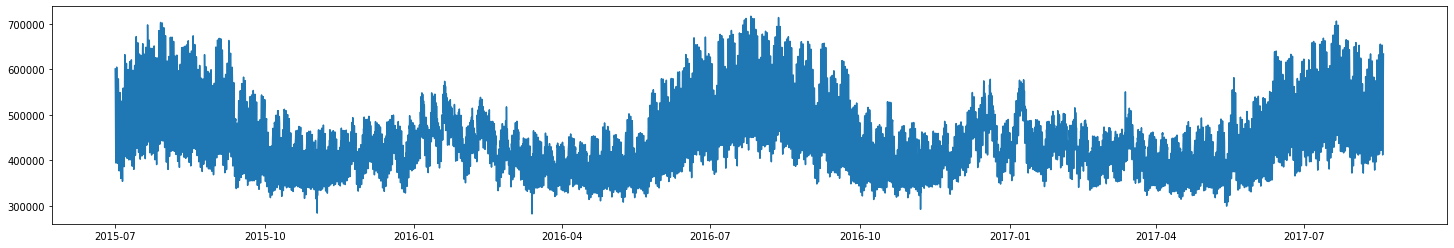

In [102]:
fig = plt.figure()
ax = plt.axes()


#plt.figure(figsize = (25,5))

ax.plot(time, power);

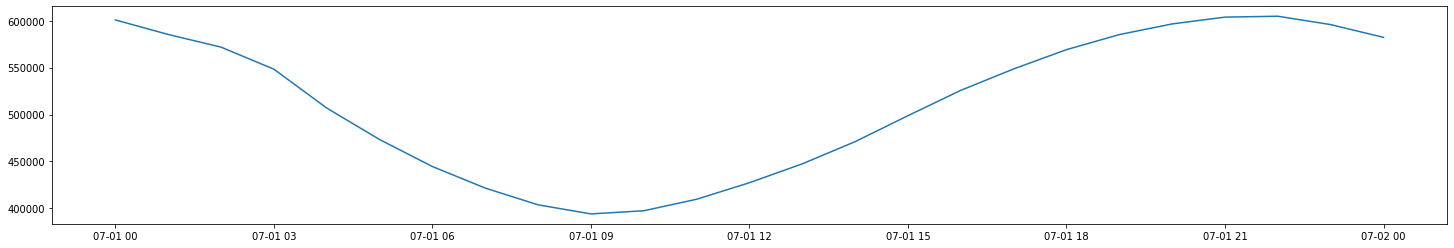

In [9]:
fig = plt.figure()
ax = plt.axes()



ax.plot(time[:25], power[:25]);


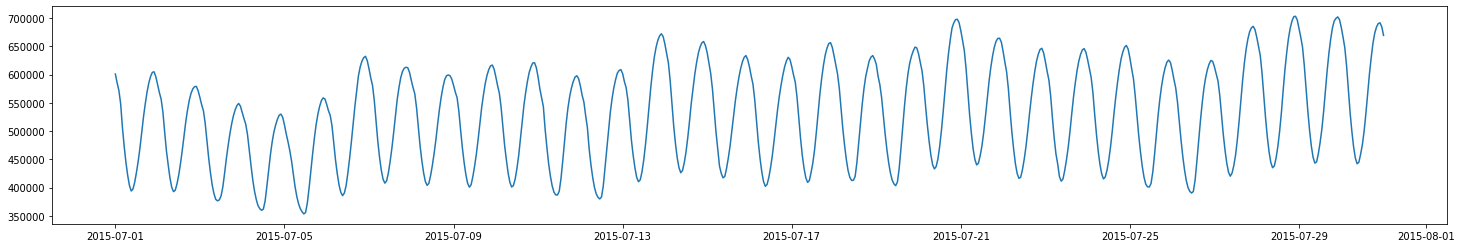

In [10]:
fig = plt.figure()
ax = plt.axes()



ax.plot(time[:721], power[:721]);


In [11]:
faux_t = np.arange(0,len(time))
print(len(faux_t))

18717


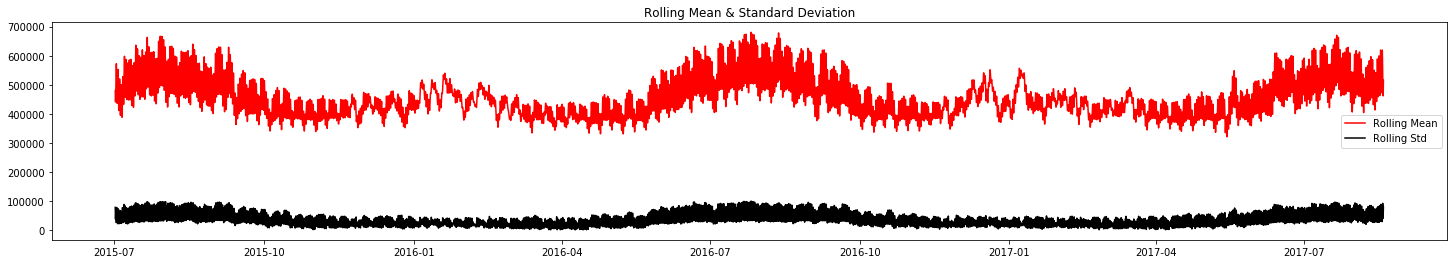

Results of Dickey-Fuller Test:
Test Statistic                -6.209709e+00
p-value                        5.545942e-08
#Lags Used                     4.500000e+01
Number of Observations Used    1.867100e+04
Critical Value (1%)           -3.430700e+00
dtype: float64
Test Statistic                -6.209709e+00
p-value                        5.545942e-08
#Lags Used                     4.500000e+01
Number of Observations Used    1.867100e+04
Critical Value (1%)           -3.430700e+00
Critical Value (5%)           -2.861695e+00
dtype: float64
Test Statistic                -6.209709e+00
p-value                        5.545942e-08
#Lags Used                     4.500000e+01
Number of Observations Used    1.867100e+04
Critical Value (1%)           -3.430700e+00
Critical Value (5%)           -2.861695e+00
Critical Value (10%)          -2.566852e+00
dtype: float64


In [12]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries,q):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()


    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries[q], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        print(dfoutput)

test_stationarity(dfpow, 'Power')

We se that the series is stationary and also periodic. We will now apply linear and ridge regression to see if a model trained with the previous four hours of usage in the contiguous 48 states can be used to predict power usage in the pacific north west states.

In [13]:
X_train_4 = []
#y_train = []
X_test_4 = []

y_train_4 = []
y_test_4 = []

def make_sets(grp, in_list, ox_train, ox_test, oy_train, oy_test):
    for i in range(0,int(.8*len(in_list))):
        ox_train.append(in_list[i:i + grp])
    for i in range(int(.8*len(in_list)),len(in_list) - grp - 1):
        ox_test.append(in_list[i:i + grp])
    for i in in_list[grp:int(.8*len(in_list)) + grp]:
        oy_train.append(i)
    for i in in_list[int(.8*len(in_list)) + grp:len(in_list) - 1:]:
        oy_test.append(i)

make_sets(4, power, X_train_4, X_test_4, y_train_4, y_test_4)


print(len(X_test_4), len(y_test_4), len(X_train_4), len(y_train_4), X_train_4[1], y_train_4[0], X_test_4[len(X_test_4)-1], y_test_4[len(y_test_4) -2])

3739 3739 14973 14973 [585365, 571857, 548363, 506969] 506969 [524297, 552177, 577349, 599501] 599501


In [14]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV


clf = Ridge()
pars = {'alpha': [.001, .001, .01, .1, 1, 2, 5]}
CV_clf = GridSearchCV(estimator=clf, param_grid = pars, scoring = 'neg_mean_squared_error', cv= 5)
CV_clf.fit(X_train_4, y_train_4)
CV_clf.best_params_

{'alpha': 5}

In [15]:


clf = Ridge(alpha = 5.0)
clf.fit(X_train_4, y_train_4)
pred1 = clf.predict(X_test_4)
print(clf.score(X_test_4, np.asarray(y_test_4)))
print(sk.metrics.r2_score(y_test_4, pred1), sk.metrics.mean_absolute_error(y_test_4, pred1), sk.metrics.mean_absolute_error(y_test_4, pred1)/np.mean(y_test_4))
#print(clf2.score(X_test_4, np.asarray(y_test_4)))


0.9968291356856338
0.9968291356856338 3452.468796084539 0.007473186955875802


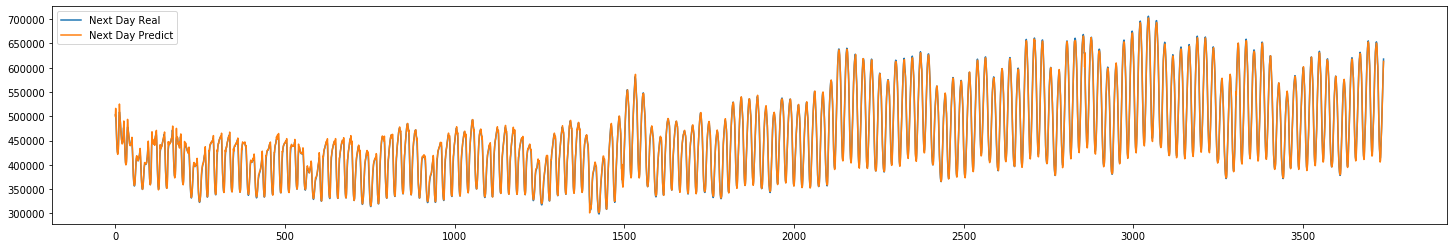

In [16]:


fig=plt.figure()
ax = plt.axes()
ax.plot(np.arange(0,len(y_test_4) ), y_test_4, label = 'Next Day Real')
ax.plot(np.arange(0,len(y_test_4)), pred1, label =  'Next Day Predict')

plt.legend(loc="upper left")
plt.show()


In [17]:
time_NW =[]
power_NW = []

for i, k in df[df['name'] == 'Demand for Northwest (region), Hourly']['data'][0].items():
    time_NW.append(i)
    power_NW.append(k)
time_NW = time_NW[::-1]
power_NW = power_NW[::-1]
pd.to_datetime(time_NW)

X_train_4_NW = []
#y_train = []
X_test_4_NW = []

y_train_4_NW = []
y_test_4_NW = []

def make_sets(grp, in_list, ox_train, ox_test, oy_train, oy_test):
    for i in range(0,int(.8*len(in_list))):
        ox_train.append(in_list[i:i + grp])
    for i in range(int(.8*len(in_list)),len(in_list) - grp - 1):
        ox_test.append(in_list[i:i + grp])
    for i in in_list[grp:int(.8*len(in_list)) + grp]:
        oy_train.append(i)
    for i in in_list[int(.8*len(in_list)) + grp:len(in_list) - 1:]:
        oy_test.append(i)

make_sets(4, power_NW, X_train_4_NW, X_test_4_NW, y_train_4_NW, y_test_4_NW)

print(len(time_NW), time_NW[0], X_test_4_NW[0], np.mean(X_test_4_NW))
#print(len(X_test_4_NW), len(y_test_4_NW), len(X_train_4_NW), len(y_train_4_NW), X_train_4_NW[1], y_train_4_NW[0])
#, X_test_4[len(X_test_4)-1], y_test_4[len(y_test_4) -2])



18717 20150701T00Z [39024, 38623, 38799, 39240] 39022.55121690292


In [18]:
clf2 = Ridge(alpha = 5.0)
clf2.fit(X_train_4, y_train_4)

#clf2.fit(X_train_4_NW, y_train_4_NW)
pred2 = clf2.predict(X_test_4_NW)

#clf2.score(pred.reshape(-1,1), np.array(y_test_4_NW))
#r2 = clf2.score(np.array(X_test_4_NW).reshape(-1,1),clf2.predict(np.array(X_test_4_NW)))
mae = sk.metrics.mean_absolute_error(y_test_4_NW, pred2)
#r2 = sk.metrics.root_mean_squared_error(y_test_4_NW, pred2)

print(sk.metrics.r2_score(y_test_4_NW, np.array(pred2)), mae, mae/np.mean(y_test_4_NW))

-3.071783019667925 12063.66073877254 0.3091236120826737


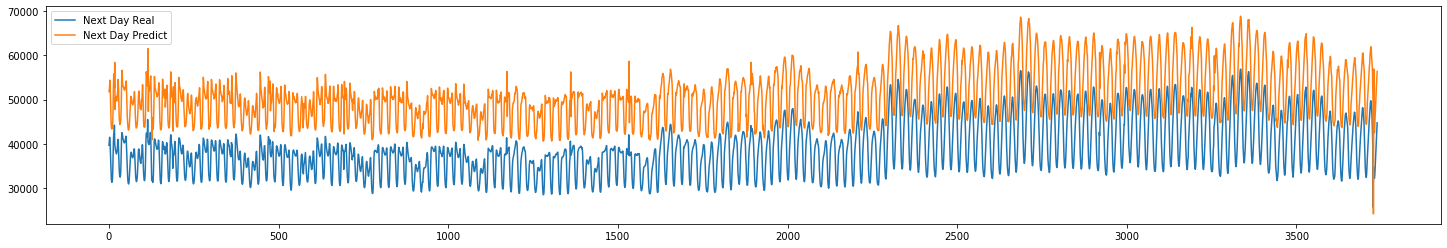

In [19]:
l = [x*1 for x in pred2]
fig=plt.figure()
ax = plt.axes()
ax.plot(np.arange(0,len(y_test_4_NW)), y_test_4_NW, label = 'Next Day Real')
#ax.plot(np.arange(0,len(y_test_4_NW)), list(l), label = 'Next Day Real')
ax.plot(np.arange(0,len(y_test_4_NW)), pred2, label =  'Next Day Predict')

plt.legend(loc="upper left")
plt.show()



In [20]:


from sklearn import linear_model
clf3 = linear_model.LinearRegression(normalize = True)
clf3.fit (X_train_4, y_train_4)
pred3 = clf3.predict(X_test_4_NW)


np.array(y_test_4_NW).reshape(-1,1).shape
print(sk.metrics.r2_score(y_test_4_NW, pred3), sk.metrics.mean_absolute_error(y_test_4_NW, pred3), sk.metrics.mean_absolute_error(y_test_4_NW, pred3)/np.mean(y_test_4_NW))

-3.071783019468932 12063.660738476266 0.3091236120750819


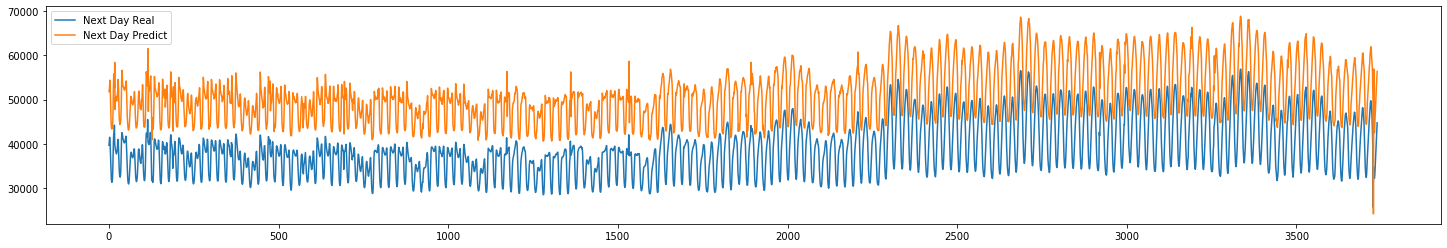

In [21]:
fig=plt.figure()
ax = plt.axes()
ax.plot(np.arange(0,len(y_test_4_NW)), y_test_4_NW, label = 'Next Day Real')
#ax.plot(np.arange(0,len(y_test_4_NW)), list(l), label = 'Next Day Real')
ax.plot(np.arange(0,len(y_test_4_NW)), pred3, label =  'Next Day Predict')

plt.legend(loc="upper left")
plt.show()


In [104]:
dfpow_NW = pd.DataFrame({'Time':time_NW, 'Power':power_NW})
dfpow_NW['Time'] = pd.to_datetime(dfpow_NW['Time'])
dfpow_NW.dropna(axis = 1, inplace = True)
dfpow_NW.head()



,Time,Power
0,2015-07-01 00:00:00+00:00,57182
1,2015-07-01 01:00:00+00:00,56776
2,2015-07-01 02:00:00+00:00,55896
3,2015-07-01 03:00:00+00:00,54214
4,2015-07-01 04:00:00+00:00,52856


Next we see how how well the same techniques work with a moving average.

In [23]:
#Here we have rolling values for the contiguous 48 states and add a seasonal value to them.

dfpow = pd.DataFrame({'Time':time, 'Power':power})
#dfpow['Year'] = pd.DatetimeIndex(dfpow['Time']).year
dfpow['Month'] = pd.DatetimeIndex(dfpow['Time']).month
#dfpow['Day'] = pd.DatetimeIndex(dfpow['Time']).day
daily_mean = dfpow['Power'].rolling(24).mean()
daily_std = dfpow['Power'].rolling(24).std()
daily_sum  = dfpow['Power'].rolling(24).sum()
day1_mean = np.mean(dfpow['Power'][0:25])
day1_std = np.std(dfpow['Power'][0:25])
day1_sum = np.sum(dfpow['Power'][0:25])
df_pow_daily_48 = dfpow.drop(['Power', 'Time'], axis =1)
#df_pow_daily_48 = df_pow_daily_48.groupby(['Day'])
#df_pow_daily_48.drop_duplicates(['Day'], inplace = True)
df_pow_daily_48['Daily Mean'] = daily_mean
df_pow_daily_48['Daily STD'] = daily_std
df_pow_daily_48['Daily Sum'] = daily_sum
df_pow_daily_48['Daily Mean'][0] = day1_mean
df_pow_daily_48['Daily STD'][0] = day1_std
df_pow_daily_48['Daily Sum'][0] = day1_sum
df_pow_daily_48['Next Day'] = df_pow_daily_48['Daily Mean'].shift(periods = -1)
df_pow_daily_48['Three Days'] = df_pow_daily_48['Daily Mean'].shift(periods = -3)

summer = []
for i in df_pow_daily_48.Month:
    if i in [6,7,8]:
        summer.append(1)
    else:
        summer.append(0)
df_pow_daily_48['Summer'] = summer
#df_pow_daily_48.drop('Month', inplace = True)
#dfpow.fillna(method = 'pad', inplace = True)
#dfpow['Hour'] = pd.DatetimeIndex(dfpow['Time']).hour
dfpow.set_index('Time', inplace = True)
#dfpow.dtypes
print(day1_mean)
df_pow_daily_48.drop('Month', inplace = True, axis = 1)
df_pow_daily_48.dropna(inplace = True)

df_pow_daily_48.shape

512598.0


/home/hdawg/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/hdawg/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/hdawg/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(18691, 6)

In [24]:
dfpow_NW['Month'] = pd.DatetimeIndex(dfpow_NW['Time']).month
#dfpow_NW['Day'] = pd.DatetimeIndex(dfpow_NW['Time']).day
daily_mean = dfpow_NW['Power'].rolling(24).mean()
daily_std = dfpow_NW['Power'].rolling(24).std()
daily_sum  = dfpow_NW['Power'].rolling(24).sum()
day1_mean = np.mean(dfpow_NW['Power'][0:25])
day1_std = np.std(dfpow_NW['Power'][0:25])
day1_sum = np.sum(dfpow_NW['Power'][0:25])
df_pow_daily_nw = dfpow_NW.drop(['Power', 'Time'], axis =1)
#df_pow_daily_48 = df_pow_daily_48.groupby(['Day'])
#df_pow_daily_48.drop_duplicates(['Day'], inplace = True)
df_pow_daily_nw['Daily Mean'] = daily_mean
df_pow_daily_nw['Daily STD'] = daily_std
df_pow_daily_nw['Daily Sum'] = daily_sum
df_pow_daily_nw['Daily Mean'][0] = day1_mean
df_pow_daily_nw['Daily STD'][0] = day1_std
df_pow_daily_nw['Daily Sum'][0] = day1_sum
df_pow_daily_nw['Next Day'] = df_pow_daily_nw['Daily Mean'].shift(periods = -1)
df_pow_daily_nw['Three Days'] = df_pow_daily_nw['Daily Mean'].shift(periods = -3)
summer = []
for i in df_pow_daily_nw.Month:
    if i in [6,7,8]:
        summer.append(1)
    else:
        summer.append(0)

df_pow_daily_nw['Summer'] = summer
#df_pow_daily_48.drop('Month', inplace = True)
#dfpow.fillna(method = 'pad', inplace = True)
#dfpow['Hour'] = pd.DatetimeIndex(dfpow['Time']).hour
#dfpow.set_index('Time', inplace = True)
#dfpow.dtypes
print(day1_mean)
df_pow_daily_nw.drop('Month', inplace = True, axis = 1)
df_pow_daily_nw.dropna(inplace = True)

df_pow_daily_nw.head()

47929.68


/home/hdawg/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/hdawg/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/hdawg/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Daily Mean,Daily STD,Daily Sum,Next Day,Three Days,Summer
23,47592.458333,7491.705094,1142219.0,47544.166667,47432.958333,1
24,47544.166667,7430.690159,1141060.0,47491.500000,47391.375000,1
25,47491.500000,7366.615777,1139796.0,47432.958333,47351.750000,1
26,47432.958333,7302.223524,1138391.0,47391.375000,47312.625000,1
27,47391.375000,7264.674258,1137393.0,47351.750000,47282.500000,1


Here we break the data into test and validation sets based on rolling figures.

In [25]:
Xd_train_1 = df_pow_daily_48[['Daily Mean', 'Daily STD', 'Daily Sum', 'Summer']].iloc[:int(.8*len(df_pow_daily_48.Summer))]
Xd_val_1 = df_pow_daily_48[['Daily Mean', 'Daily STD', 'Daily Sum', 'Summer']].iloc[int(.8*len(df_pow_daily_48.Summer)):len(df_pow_daily_48.Summer) -1]
yd_train_1 = df_pow_daily_48[['Next Day']].iloc[:int(.8*len(df_pow_daily_48.Summer))]
yd_val_1 = df_pow_daily_48[['Next Day']].iloc[int(.8*len(df_pow_daily_48.Summer)):len(df_pow_daily_48.Summer) -1]


Xd_train_3 = df_pow_daily_48[['Daily Mean', 'Daily STD', 'Daily Sum', 'Summer']].iloc[:int(.8*len(df_pow_daily_48.Summer))]
Xd_val_3 = df_pow_daily_48[['Daily Mean', 'Daily STD', 'Daily Sum', 'Summer']].iloc[int(.8*len(df_pow_daily_48.Summer)):len(df_pow_daily_48.Summer) -1]
yd_train_3 = df_pow_daily_48[['Three Days']].iloc[:int(.8*len(df_pow_daily_48.Summer))]
yd_val_3 = df_pow_daily_48[['Three Days']].iloc[int(.8*len(df_pow_daily_48.Summer)):len(df_pow_daily_48.Summer) -1]

In [26]:


clf4 = Ridge()
pars = {'alpha': [.001, .001, .01, .1, 1, 2, 5, 5.5, 6, 7, 8, 9, 10]}
CV_clf4 = GridSearchCV(estimator=clf4, param_grid = pars, scoring = 'neg_mean_squared_error', cv= 10)
CV_clf4.fit(Xd_train_1, yd_train_1)
CV_clf4.best_params_

/home/hdawg/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.47228e-18): result may not be accurate.
  overwrite_a=True).T
/home/hdawg/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.00291e-18): result may not be accurate.
  overwrite_a=True).T
/home/hdawg/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.48417e-18): result may not be accurate.
  overwrite_a=True).T
/home/hdawg/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.19758e-18): result may not be accurate.
  overwrite_a=True).T
/home/hdawg/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.15653e-19): result may not be accurate.
  overwrite_a=True).T
/home/hdawg/anaconda3/lib/pyth

{'alpha': 10}

In [27]:
clf4 = Ridge(alpha = 10.0)
clf4.fit(Xd_train_1, yd_train_1)
clf4.score(Xd_val_1, np.asarray(yd_val_1))


0.9996866579551986

In [28]:
pred_nw_ridge = clf4.predict(df_pow_daily_nw[['Daily Mean', 'Daily STD', 'Daily Sum', 'Summer']])
r2_4 = sk.metrics.r2_score(df_pow_daily_nw['Next Day'], pred_nw_ridge)
print(r2_4)

0.9922183104811686


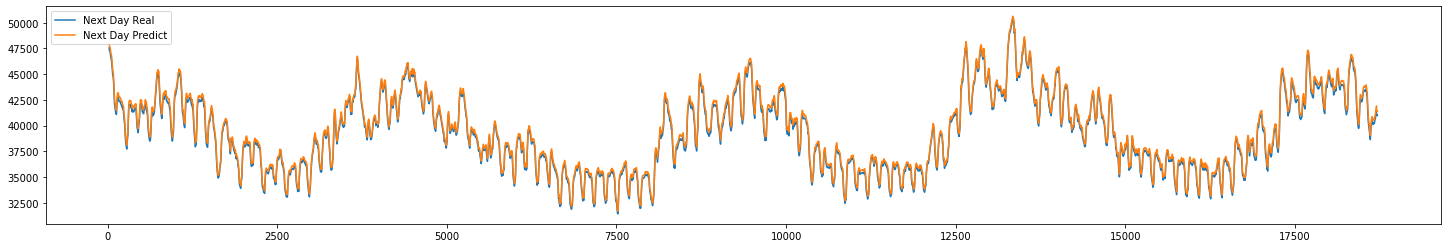

In [29]:
fig=plt.figure()
ax = plt.axes()
ax.plot(df_pow_daily_nw.index, df_pow_daily_nw['Next Day'], label = 'Next Day Real')
ax.plot( df_pow_daily_nw.index, pred_nw_ridge, label =  'Next Day Predict')

plt.legend(loc="upper left")
plt.show()



In [30]:
r2s = []
days = np.arange(1,21)

for i in days:
    #print(df_pow_daily_nw[['Daily Mean', 'Daily STD', 'Daily Sum', 'Summer']].iloc[:len(df_pow_daily_48.Summer) -i].shape)
    df_test = df_pow_daily_nw[['Daily Mean', 'Daily STD', 'Daily Sum', 'Summer']].iloc[:len(df_pow_daily_48.Summer) -i]
    df_test['Future'] = df_pow_daily_nw['Daily Mean'].shift(periods = -i)
    #label = 'i' + 'Days'
    #df_pow_daily_nw['Daily Mean'].shift(periods = -i).dropna(inplace = True)
    #pred_nw_ahead = clf4.predict(df_pow_daily_nw[['Daily Mean', 'Daily STD', 'Daily Sum', 'Summer']].iloc[:len(df_pow_daily_48.Summer) -i])
    pred_nw_ahead = clf4.predict(df_test[['Daily Mean', 'Daily STD', 'Daily Sum', 'Summer']])
    #print(pred_nw_ahead[len(pred_nw_ahead)-1], len(pred_nw_ahead), len(df_pow_daily_nw['Daily Mean'].shift(periods = -i)))
    #r2 = sk.metrics.r2_score(df_pow_daily_nw['Daily Mean'].shift(periods = -i), pred_nw_ahead)
    r2 = sk.metrics.r2_score(df_test['Future'], pred_nw_ahead)
    #print(r2)
    r2s.append(r2)
    
    



Here we plot the r^2 score of the predictor against distance in the future.

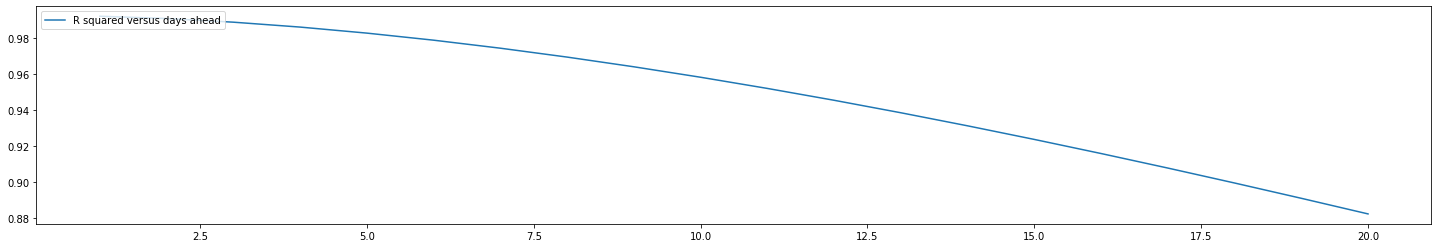

In [31]:
fig=plt.figure()
ax = plt.axes()
ax.plot(days, r2s, label = 'R squared versus days ahead')
#ax.plot( df_pow_daily_nw.index, pred_nw_ridge_3, label = 'Three Days Predict')
plt.legend(loc="upper left")
plt.show()


In [32]:
#Here we add a 'summer' column to the original data sets, distinct from previous efforts for aggergation based on the linear day.
days = []
chunk = np.arange(1,int(len(dfpow.Power)/24)+1)
for i in chunk:
    add = [i]*24
    days.extend(add)
    
summer_dis_48 = []

for i in dfpow.Month:
    if i in [6,7,8]:
        summer_dis_48.append(1)
    else:
        summer_dis_48.append(0)
        
summer_dis_NW = []

for i in dfpow.Month:
    if i in [6,7,8]:
        summer_dis_NW.append(1)
    else:
        summer_dis_NW.append(0)
        


dfpow['Summer'] = summer_dis_48

dfpow_NW['Summer'] = summer_dis_NW

dfpow.head()

,Power,Month,Summer
Time,,,
2015-07-01 00:00:00+00:00,600819,7,1
2015-07-01 01:00:00+00:00,585365,7,1
2015-07-01 02:00:00+00:00,571857,7,1
2015-07-01 03:00:00+00:00,548363,7,1
2015-07-01 04:00:00+00:00,506969,7,1


In [33]:
dfdays = pd.DataFrame({'Linear':days})
dfdays.head()

,Linear
0,1
1,1
2,1
3,1
4,1


In [34]:
#We add the seasonal column here.
df_days_48 = dfpow[['Power', 'Summer']]
df_days_48.reset_index(inplace = True)
df_days_48['Linear'] = pd.Series(days)
#pd.concat([df_days_48,dfsmmr], ignore_index=True, axis=1)
#pd.concat([df_days_48,dfdays], ignore_index=True, axis=1)
df_days_48.dropna(inplace = True)
df_days_48.drop(df_days_48[['Time']], inplace = True, axis = 1)

df_days_NW = dfpow_NW[['Power', 'Summer']]
df_days_NW.reset_index(inplace = True)
df_days_NW['Linear'] = pd.Series(days)

#df_days_48.merge(dfdays,left_index=True, right_index = True)
#df_days_48.dropna(inplace = True)
#dfpow.head()
df_days_NW.head()

/home/hdawg/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/hdawg/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/hdawg/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stab

,index,Power,Summer,Linear
0,0,57182,1,1.0
1,1,56776,1,1.0
2,2,55896,1,1.0
3,3,54214,1,1.0
4,4,52856,1,1.0


In [35]:
dfpow.drop(['Month'], inplace = True, axis = 1)

dfpow_NW.drop(['Month'], inplace = True, axis = 1)


In [36]:
#Here aggregate data is pushed to a data set for linearly occuring days.
    
#days = list(zip(days))
print(len(days), len(dfpow_NW.Power)/24, days[len(days)-1])
#dfpow_NW.shape
#dfpow['Linear'] = pd.Series(days)
#dfpow.dropna(inplace = True)
#dfpow_NW['Linear'] = pd.Series(days)
#dfpow_NW.dropna(inplace = True)
dfmn = df_days_48.groupby('Linear').agg({'Power':['mean']})
dfsum = df_days_48.groupby('Linear').agg({'Power':['sum']})
dfstd = df_days_48.groupby('Linear').agg({'Power':['std']})
dfmin = df_days_48.groupby('Linear').agg({'Power':['min']})
dfmax = df_days_48.groupby('Linear').agg({'Power':['max']})
dfsmmr = df_days_48.groupby('Linear').agg({'Summer':['mean']})


dfmn_NW = df_days_NW.groupby('Linear').agg({'Power':['mean']})
dfsum_NW = df_days_NW.groupby('Linear').agg({'Power':['sum']})
dfstd_NW = df_days_NW.groupby('Linear').agg({'Power':['std']})
dfmin_NW = df_days_NW.groupby('Linear').agg({'Power':['min']})
dfmax_NW = df_days_NW.groupby('Linear').agg({'Power':['max']})
dfsmmr_NW = df_days_NW.groupby('Linear').agg({'Summer':['mean']})


df_48_merge = pd.concat([dfmn,dfstd,dfsum,dfmin,dfmax,dfsmmr], axis = 1)
df_NW_merge = pd.concat([dfmn_NW,dfstd_NW,dfsum_NW,dfmin_NW,dfmax_NW,dfsmmr_NW], axis = 1)

df_NW_merge.head()

18696 779.875 779


Power                                     Summer
                mean          std      sum    min    max   mean
Linear                                                         
1.0     47592.458333  7491.705094  1142219  36421  57182      1
2.0     46720.791667  7089.354971  1121299  36202  56023      1
3.0     45252.750000  7128.326044  1086066  35210  55539      1
4.0     43517.708333  6821.008822  1044425  33747  54087      1
5.0     41350.958333  5792.749024   992423  32874  49607      1

In [105]:
#Time shifted columns for mean use of are created here.
#print(df_48_merge.columns)
df_48_merge[('Power', 'next day')] = df_48_merge[('Power', 'mean')].shift(periods = -1)
df_48_merge.dropna(inplace = True)
df_NW_merge[('Power', 'next day')] = df_NW_merge[('Power', 'mean')].shift(periods = -1)
df_NW_merge.dropna(inplace = True)
df_NW_merge.head()

Power                                     Summer         Power
                mean          std      sum    min    max   mean      next day
Linear                                                                       
1.0     47592.458333  7491.705094  1142219  36421  57182      1  46720.791667
2.0     46720.791667  7089.354971  1121299  36202  56023      1  45252.750000
3.0     45252.750000  7128.326044  1086066  35210  55539      1  43517.708333
4.0     43517.708333  6821.008822  1044425  33747  54087      1  41350.958333
5.0     41350.958333  5792.749024   992423  32874  49607      1  42446.541667

In [96]:
#Training and test sets based on the contiguous 48 states and north western states are created here.

#Xd_train_1 = df_48_merge[[( 'Power', 'mean'),( 'Power',  'std'),( 'Power',  'sum'),( 'Power',  'min'),( 'Power',  'max'),('Summer', 'mean')]].iloc[:int(.8*len(df_48_merge.index))]

Xd_train_1 = df_48_merge[[( 'Power', 'mean'),( 'Power',  'std'), ('Summer', 'mean')]].iloc[:int(.8*len(df_48_merge.index))]



#Xd_val_1 = df_48_merge[[( 'Power', 'mean'),( 'Power',  'std'),( 'Power',  'sum'),( 'Power',  'min'),( 'Power',  'max'),('Summer', 'mean')]].iloc[int(.8*len(df_48_merge.index)):len(df_48_merge.index) -1]

Xd_val_1 = df_48_merge[[( 'Power', 'mean'),( 'Power',  'std'), ('Summer', 'mean')]].iloc[int(.8*len(df_48_merge.index)):len(df_48_merge.index) -1]


yd_train_1 = df_48_merge[[('Power', 'next day')]].iloc[:int(.8*len(df_48_merge.index))]
yd_val_1 = df_48_merge[[('Power', 'next day')]].iloc[int(.8*len(df_48_merge.index)):len(df_48_merge.index) -1]


#Xd_train_NW = df_48_merge[[( 'Power', 'mean'),( 'Power',  'std'),( 'Power',  'sum'),( 'Power',  'min'),( 'Power',  'max'),('Summer', 'mean')]].iloc[:int(.8*len(df_48_merge.index))]

Xd_train_NW = df_48_merge[[( 'Power', 'mean'),( 'Power',  'std'), ('Summer', 'mean')]].iloc[:int(.8*len(df_48_merge.index))]
, ('Power', 'min'), ('Power', 'max')

#Xd_val_NW = df_NW_merge[[( 'Power', 'mean'),( 'Power',  'std'),( 'Power',  'sum'),( 'Power',  'min'),( 'Power',  'max'),('Summer', 'mean')]].iloc[int(.8*len(df_48_merge.index)):len(df_48_merge.index) -1]

Xd_val_NW = df_NW_merge[[( 'Power', 'mean'),( 'Power',  'std'), ('Summer', 'mean')]].iloc[int(.8*len(df_48_merge.index)):len(df_48_merge.index) -1]


yd_train_NW = df_NW_merge[[('Power', 'next day')]].iloc[:int(.8*len(df_NW_merge.index))]
yd_val_NW = df_NW_merge[[('Power', 'next day')]].iloc[int(.8*len(df_48_merge.index)):len(df_48_merge.index) -1]

In [106]:


#The model is fitted.


#clf5 = linear_model.Lasso()
clf5 = Ridge()
pars = {'alpha': [.001, .001, .01, .1, 1, 2, 5, 5.5, 6, 7, 8, 9, 10, 100, 1000, 10000]}
CV_clf5 = GridSearchCV(estimator=clf5, param_grid = pars, scoring = 'neg_mean_squared_error', cv= 10)
CV_clf5.fit(Xd_train_1, yd_train_1)
CV_clf5.best_params_



{'alpha': 1}

In [98]:
#clf5 = Ridge(alpha = 10.0)
clf5 = linear_model.Lasso(alpha = 1.0)
#clf5.fit(Xd_train_1, yd_train_1)
clf5.fit(Xd_train_1, yd_train_1)

#pred_nw = clf5.predict(Xd_train_NW)
pred_nw = clf5.predict(Xd_train_NW)

r2_NW_1 = sk.metrics.r2_score(pred_nw, yd_train_NW)
print(clf5.score(Xd_val_1, np.asarray(yd_val_1)),r2_NW_1)

0.8868422262893965 -64.21085879158588


Here we get a series of r^2 values for the north western set of average power use based on the model trained with the 48 contiguous states total.

In [99]:
r2s = []
da = np.arange(1,21)

for i in da:
    #print(df_pow_daily_nw[['Daily Mean', 'Daily STD', 'Daily Sum', 'Summer']].iloc[:len(df_pow_daily_48.Summer) -i].shape)
    #df_test = df_NW_merge[[( 'Power', 'mean'),( 'Power',  'std'),( 'Power',  'sum'),( 'Power',  'min'),( 'Power',  'max'),('Summer', 'mean')]].iloc[:len(df_NW_merge.index) -(i)]
    df_test = df_NW_merge[[('Power', 'mean'),('Power', 'std'),('Summer', 'mean')]].iloc[:len(df_NW_merge.index) -(i)]
    df_test['Future'] = df_NW_merge[('Power', 'mean')].shift(periods = -i)

    #pred_nw_ahead = clf5.predict(df_test[[( 'Power', 'mean'),( 'Power',  'std'),( 'Power',  'sum'),( 'Power',  'min'),( 'Power',  'max'),('Summer', 'mean')]])
    pred_nw_ahead = clf5.predict(df_test[[( 'Power', 'mean'),( 'Power',  'std'),('Summer', 'mean')]])
    
    #print(pred_nw_ahead[len(pred_nw_ahead)-1], len(pred_nw_ahead), len(df_pow_daily_nw['Daily Mean'].shift(periods = -i)))
    #r2 = sk.metrics.r2_score(df_pow_daily_nw['Daily Mean'].shift(periods = -i), pred_nw_ahead)
    r2 = sk.metrics.r2_score(df_test['Future'], pred_nw_ahead)
    print(r2)
    r2s.append(r2)

-388.4520606617402
-390.28894564084686
-391.256385545451
-391.4246611410927
-390.9771998905613
-390.71765127422174
-390.4865533350348
-390.33890152182676
-390.16029386529107
-389.7242374416255
-389.033785544384
-388.3387113563303
-387.7645286070062
-387.3483009756305
-386.993653079221
-386.68167819586347
-386.37146354938074
-385.78338208313136
-385.1046863332184
-384.71735651810405
